In [6]:
import pandas as pd
import numpy as np
import scanpy as sc
import networkx as nx
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import importlib
import random
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import Delaunay
from scipy.sparse import csr_matrix
from itertools import chain
random.seed(123)

In [32]:
section_id = '151676'
parent_dir = '/n/fs/ragr-data/datasets/spatial_transcriptomics/DLPFC_data'
adata = sc.read_h5ad(os.path.join(parent_dir, section_id + ".h5ad"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
nop = 100
N = nop ** 2

# Generate positions
pos = np.array(np.meshgrid(np.arange(1, int(np.sqrt(N)) + 1), 
                           np.arange(1, int(np.sqrt(N)) + 1))).T.reshape(-1, 2)
pos = np.concatenate((pos, pos[::-1]), axis=0)
pos = np.unique(pos, axis=0)

# Assign row and column names
pos_names = [f'cell{i+1}' for i in range(N)]
df_pos = pd.DataFrame(pos, columns=['x', 'y'])
df_pos.index = pos_names
#pos = np.column_stack((pos, pos_names))

# Jitter
pos_j = df_pos + np.random.uniform(-0.2, 0.2, size = (N,2))

# Induce warping
#pos_w = 1.01 ** pos_j
pos_w = pos_j
#pos_w = 100 * pos_w

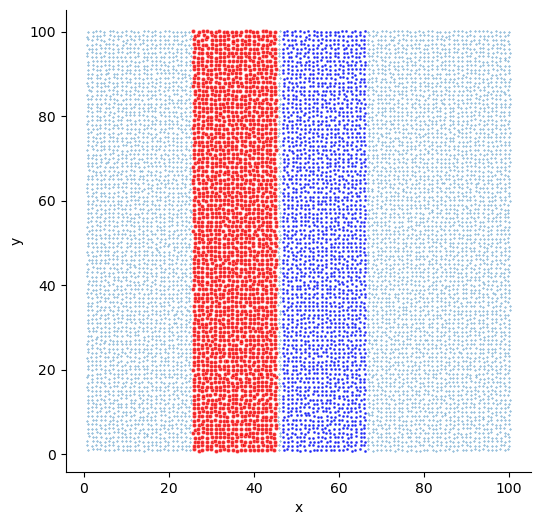

In [27]:
# Plotting
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(pos_w.x, pos_w.y,s=0.1);

start_x_vec = list(range(2500,4500,100))
gaps = list(range(40,0,-2))
red_df = pd.DataFrame()
blue_df = pd.DataFrame()
for i in range(len(gaps)):
    start_x = start_x_vec[i]
    gap = gaps[i]
    tmp = pos_w.iloc[ start_x: start_x + nop, ].copy()
    tmp.loc[:, 'gap'] = gap
    red_df = pd.concat([ red_df,  tmp.copy() ], axis = 0)
    tmp = pos_w.iloc[ start_x + gap * nop: start_x + (gap+1) * nop, ].copy()
    tmp.loc[:, 'gap'] = gap
    blue_df = pd.concat([ blue_df,  tmp.copy() ], axis = 0)
    
    sns.scatterplot(data = pos_w.iloc[ start_x: start_x + nop, ], x = "x", y = "y", s = 9, ax=ax, alpha=0.8, color='r');    
    sns.scatterplot(data = pos_w.iloc[ start_x + gap * nop: start_x + (gap+1) * nop, ], x = "x", y = "y", s = 4, ax=ax, alpha=0.8, color='blue');
sns.despine()

In [33]:
red_df.shape

(2000, 3)

In [36]:
sim_edge_list_df = pd.DataFrame(sim_edge_list, columns = ['source', 'target', 'distance'])

In [35]:
sim_coords = pos_w[[ 'x', 'y']].values
sim_edge_list = []
for i in range(len(gaps)):
    start_x = start_x_vec[i]
    gap = gaps[i]
    sim_edge_list += [(i,j,euclidean_distances(
        sim_coords[np.newaxis, i, :], 
        sim_coords[np.newaxis, j, :]
    )[0][0]) for (i,j) in zip(list(range(start_x , start_x + nop)), list(range(start_x + gap * nop, start_x + (gap+1) * nop)) ) ]

[40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2]

In [67]:
def sample_from_copula_dist(
    n_array,
    mu_x, 
    mu_y,
    coeff_list,
    dist,
    l = None,
    t = 0
):    
    if l is None:
        l = max(dist)
    lam_x = (n_array * np.exp(mu_x)) * np.exp(-(t * (dist/l**2)))
    lam_y = (n_array * np.exp(mu_y)) * np.exp(-(t * (dist/l**2)))

    # samples = Parallel(n_jobs=n_jobs, verbose=0)(
    #                 delayed(np.random.multivariate_normal)(
    #                     [0,0],
    #                     [[1, coeff], [coeff, 1]],
    #                     size = 1) for coeff in coeff_list)
    # samples = np.array(list(chain(*(samples))))
    
    samples = np.array([np.random.multivariate_normal(
            [0,0], 
            [[1,coeff],[coeff,1]], 
            size = 1
        ).squeeze() for coeff in coeff_list])
        
    samples = pd.DataFrame(samples, columns=['x', 'y'])
    cdf_x = stats.norm.cdf(samples.x)
    cdf_y = stats.norm.cdf(samples.y)
    samples.loc[:, 'x'] = stats.poisson.ppf(cdf_x, lam_x)
    samples.loc[:, 'y'] = stats.poisson.ppf(cdf_y, lam_y)
    
    return samples

In [72]:
coeff_list = 0.7 * np.exp(-1 * sim_edge_list_df.distance * 0.01)
samples = sample_from_copula_dist(
        np.array([2342]*2000),
        -4, 
        -4, 
        coeff_list,
        red_df.gap.values,
        t = 30
    )

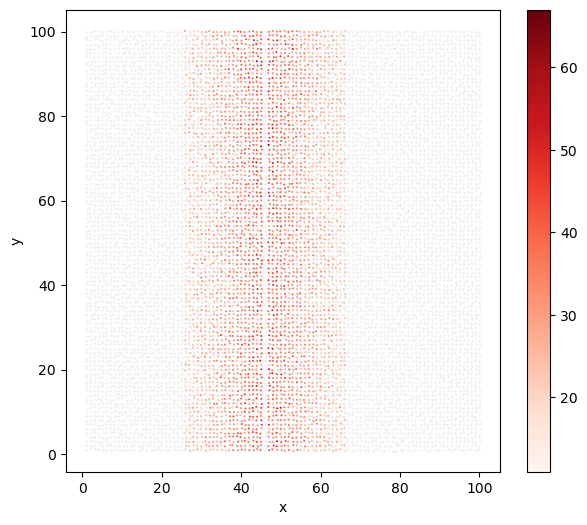

In [73]:
red_df.loc[:,'gene'] = samples.x.values
blue_df.loc[:,'gene'] = samples.y.values
tmp_dist = pd.concat([red_df, blue_df])


fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(pos_w.x, pos_w.y,s=0.01,alpha=1,color='grey');
sns.scatterplot(data= tmp_dist, x="x", y="y", hue="gene", palette="Reds",  s=2, linewidth=0, alpha=1, ax=ax)
norm = plt.Normalize(tmp_dist['gene'].min(), tmp_dist['gene'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm)
plt.show()

In [75]:
import random
n_array_sum = np.array(random.sample(list(adata.to_df().sum(1)),sim_edge_list_df.shape[0]))

In [76]:
def copula_dist_caller(args):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, global_idx = args
    _n_array = (n_array_sum * sparse_frac).astype('int')
    coeff_list = rho_zero * np.exp(-1 * sim_edge_list_df.distance * rho_one)
    
    sample = sample_from_copula_dist(
        _n_array,
        mu_x, 
        mu_y, 
        coeff_list,
        red_df.gap.values,
        t = 30
    )
    sample.columns = ['L'+str(int(global_idx)), 'R'+str(int(global_idx))]
    return sample

In [77]:
rho_zero_vec = np.linspace(-0.9, 0.9, 19)
rho_one_vec = np.array([0.01,0.05]) # make it variable later
sparse_fraction = np.array([0.1, 0.3 , 0.5, 1.0])
mu_x_vec = np.array([-8, -5, -3])
mu_y_vec = np.array([-8, -5, -3])

param_values = [
    sparse_fraction,
    mu_x_vec,
    mu_y_vec,
    rho_zero_vec,
    rho_one_vec
]

param_grids = np.meshgrid(*param_values, indexing='ij')
grid_points = np.column_stack([grid.ravel() for grid in param_grids])
grid_points_df = pd.DataFrame(
    grid_points, 
    columns=['sparse_frac', 'mu_x', 'mu_y' ,'rho_zero', 'rho_one']
)
grid_points_df.loc[:, 'ind'] = np.array(range(grid_points_df.shape[0])).astype('int')
arg_list = grid_points_df.values.tolist()

In [78]:
samples = Parallel(n_jobs=20, verbose=1)(
                delayed(copula_dist_caller)(
                    args) for args in arg_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    7.3s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   11.9s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   17.4s
[Parallel(n_jobs=20)]: Done 1368 out of 1368 | elapsed:   19.3s finished


In [79]:
pseudo_count = pd.concat(samples, axis = 1)

In [84]:
def show_pattern(pos_w, sim_edge_list_df, pseudo_count, i):
    tmp_source = pos_w.iloc[sim_edge_list_df.source,:].copy()
    tmp_source.loc[:,'gene'] = pseudo_count.loc[:, 'L' + str(i)].values
    tmp_end = pos_w.iloc[sim_edge_list_df.target,:].copy()
    tmp_end.loc[:,'gene'] = pseudo_count.loc[:, 'R' + str(i)].values
    tmp_dist = pd.concat([tmp_source, tmp_end])
    
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(pos_w.x, pos_w.y,s=0.01,alpha=1,color='grey');
    tmp_dist.loc[:, 'gene_log'] = np.log( tmp_dist.gene + 1 )
    sns.scatterplot(data= tmp_dist, x="x", y="y", hue="gene", palette="Reds",  s=4, linewidth=0, alpha=1, ax=ax)
    
    norm = plt.Normalize(tmp_dist['gene'].min(), tmp_dist['gene'].max())
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])
    
    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()

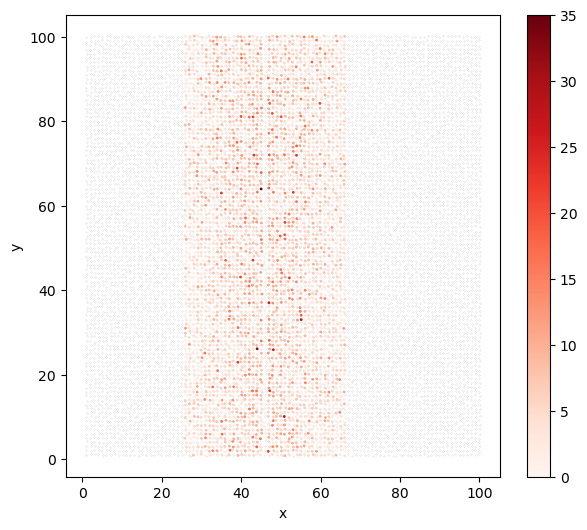

In [85]:
show_pattern(pos_w, sim_edge_list_df, pseudo_count, 494	)

In [87]:
data_list = []
i = 0
import tqdm
for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, _ = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list += [
        (
            pseudo_count.loc[:, 'L'+str(i)].values.astype('int'),
            pseudo_count.loc[:, 'R'+str(i)].values.astype('int'),
            mu_x, mu_y,
            _n_array.copy()
            
        )
    ]
    i += 1

1368it [00:00, 3755.41it/s]


In [201]:
from scipy.optimize import minimize, minimize_scalar
EPSILON = 1.1920929e-07
def get_dt_cdf(x, lam, DT=True):
    u_x = stats.poisson.cdf(x, lam).clip(EPSILON, 1 - EPSILON)
    u_x2 = stats.poisson.cdf(x-1, lam).clip(EPSILON, 1 - EPSILON)
    if DT:
        v = stats.uniform.rvs(size=len(x))
        r = u_x * v + u_x2 * (1 - v)
    else:
        r = (u_x + u_x2) / 2.0
    #r = (u_x + u_x2) / 2.0
    #r = u_x2
    # remove too low / too big
    idx_adjust = np.where(1 - r < EPSILON)[0]
    r[ idx_adjust ] = r[ idx_adjust ] - EPSILON
    idx_adjust = np.where(r < EPSILON)[0]
    r[ idx_adjust ] = r[ idx_adjust ] + EPSILON

    return stats.norm.ppf(r)
  

def log_joint_lik_perm_dist(params, umi_sum_1, umi_sum_2, x, y, dist_list,  grad_list, perm=100, DT=True, model = 'copula'):
    # get lam parameters for mu_1
    rho_zero = params[0]
    rho_one = params[1]
    coeff_list = rho_zero * np.exp(-1 * sim_edge_list_df.distance * rho_one)
    mu_1 = params[2]
    mu_2 = params[3]
    t = params[4]
    l = max(grad_list)

    lam1 = (umi_sum_1 * np.exp(mu_1)) * np.exp(-(t * (grad_list / l**2)))
    lam2 = (umi_sum_1 * np.exp(mu_2)) * np.exp(-(t * (grad_list / l**2)))
    #lam1 = umi_sum_1 * np.exp(mu_1)
    #lam2 = umi_sum_2 * np.exp(mu_2)
    
    # get z
    r_x = get_dt_cdf(x, lam1, DT=DT)
    r_y = get_dt_cdf(y, lam2, DT=DT)
    if DT:
        for _ in range(perm-1):    
            r_x += get_dt_cdf(x, lam1)
            r_y += get_dt_cdf(y, lam2)
        z = np.column_stack([r_x/perm, r_y/perm])
    else:
        z = np.column_stack([r_x, r_y])
    
    # term1
    det = 1 - coeff_list**2
    term1 = np.sum(-0.5 * (((coeff_list**2)/det) * ((z[:,0]**2) + (z[:,1] ** 2)) - 2 * (coeff_list/det) * z[:,0] * z[:,1]) )
    
    term2 = (
        np.sum(np.log( stats.poisson.pmf(x, lam1).clip(EPSILON, 1 - EPSILON) )) +
        np.sum(np.log(stats.poisson.pmf(y, lam2).clip(EPSILON, 1 - EPSILON) ))
    )
    
    term3 = np.sum(-0.5 * np.log(det+EPSILON))
    logsum = term1 + term2 + term3
   
    return -logsum


def call_optimizer_dense(
    _x, 
    _y, 
    _umi_sum_1, 
    _umi_sum_2,
    dist_list,
    grad_list,
    rho_one_start = 0.01,
    method = 'Nelder-Mead',
    perm=10,
    DT = True,
    cutoff=0.6,
    length_cutoff=20,
    model='copula',
    num_restarts = 50,
    force = False
):
    x = _x.copy()
    y = _y.copy()
    if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
        
        return ([ 0, 0, 0, 0 , 'skip' ])
    if ( (x.sum() == 0) or (y.sum() == 0) ):
        
        return ([ 0, 0, 0, 0 , 'skip' ])
    if len(x) < length_cutoff:
        
        return ([ 0, 0, 0, 0 , 'skip' ])
    umi_sum_1 = _umi_sum_1.copy()
    umi_sum_2 = _umi_sum_2.copy()
    method_type = model

    if not force:
        # If either of the arrays are too sparse we would run  
        # gaussian extimate rather than anything else
        
        if ( ((x==0).sum() / len(x) > cutoff) | ((y==0).sum() / len(y) > cutoff) ):
            
            method_type = 'skip'
        
    
    results = []
    mu_x_start = np.log(x.sum() / umi_sum_1.sum())
    mu_y_start = np.log(y.sum() / umi_sum_2.sum())
    if method_type == 'skip':
        return ([ 0, 0, 0, 0 , 'skip' ])
    else:
        for _ in range(num_restarts):
            res = minimize(
                log_joint_lik_perm_dist, 
                x0=[0.0,rho_one_start,mu_x_start,mu_y_start,1], 
                method = method, 
                bounds = [(-0.99, 0.99),
                          (0.0, 0.1),
                          (mu_x_start-5, 0),
                          (mu_y_start-5, 0),
                          (0,50)
                         ], 
                args=(umi_sum_1,umi_sum_2,x,y, dist_list,grad_list,perm,DT,"copula"), 
                tol=1e-6
            )
            results += [res.copy()]
        best_result = min(results, key=lambda x: x['fun'])
        return list(best_result['x']) + ['copula']

In [204]:
opt_res = Parallel(n_jobs=20, verbose=1)(
            delayed(call_optimizer_dense)(
        x,
        y,
        _n_array,
        _n_array,
        sim_edge_list_df.distance.values,
        red_df.gap.values,
        method='Powell',
        perm=20,
        DT=False,
        cutoff=0.9,
        num_restarts = 1
        ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=20)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=20)]: Done 450 tasks      | elapsed:   49.4s
[Parallel(n_jobs=20)]: Done 800 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done 1250 tasks      | elapsed:  3.4min
[Parallel(n_jobs=20)]: Done 1368 out of 1368 | elapsed:  3.9min finished


In [205]:
opt_res_df = pd.DataFrame(opt_res, columns=['pred_corr_zero', 'pred_corr_one' ,'pred_mu_x','pred_mu_y','t_param',
                                            'method'])

In [206]:
opt_res_df

,pred_corr_zero,pred_corr_one,pred_mu_x,pred_mu_y,t_param,method
0,0.000000,0.000000,0.000000,0.000000,skip,None
1,0.000000,0.000000,0.000000,0.000000,skip,None
2,0.000000,0.000000,0.000000,0.000000,skip,None
3,0.000000,0.000000,0.000000,0.000000,skip,None
4,0.000000,0.000000,0.000000,0.000000,skip,None
...,...,...,...,...,...,...
1363,0.990000,0.082738,-3.098558,-3.105740,22.523607,copula
1364,0.791284,0.007555,-2.999700,-2.999128,30.058814,copula
1365,0.812176,0.048106,-2.994708,-2.994972,30.226048,copula
1366,0.905463,0.010550,-2.996752,-2.994352,30.359093,copula


In [105]:
count_df_norm = pseudo_count.div(pseudo_count.sum(1), axis = 0) 
count_df_norm_log = np.log( count_df_norm + 1 )

In [106]:
data_list_norm = []

for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, i = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list_norm += [
        (
            count_df_norm.loc[:, 'L'+str(int(i))],
            count_df_norm.loc[:, 'R'+str(int(i))]
        )
    ]
    i += 1

data_list_log = []

for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, i = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list_log += [
        (
            count_df_norm_log.loc[:, 'L'+str(int(i))],
            count_df_norm_log.loc[:, 'R'+str(int(i))]
        )
    ]
    

1368it [00:00, 5052.92it/s]
1368it [00:00, 1865.15it/s]


In [217]:
grid_points_df.loc[
    ((grid_points_df.rho_zero == 0.9) | (grid_points_df.rho_zero == -0.9)) &
    (grid_points_df.mu_x == -5.0) &
    (grid_points_df.mu_y == -5.0) &
    (grid_points_df.sparse_frac == 0.3)
]

,sparse_frac,mu_x,mu_y,rho_zero,rho_one,ind
494,0.3,-5.0,-5.0,-0.9,0.01,494
495,0.3,-5.0,-5.0,-0.9,0.05,495
530,0.3,-5.0,-5.0,0.9,0.01,530
531,0.3,-5.0,-5.0,0.9,0.05,531


In [228]:
idx = 647
grid_points_df.iloc[idx:idx+1,:]

,sparse_frac,mu_x,mu_y,rho_zero,rho_one,ind
647,0.3,-3.0,-3.0,-0.9,0.05,647


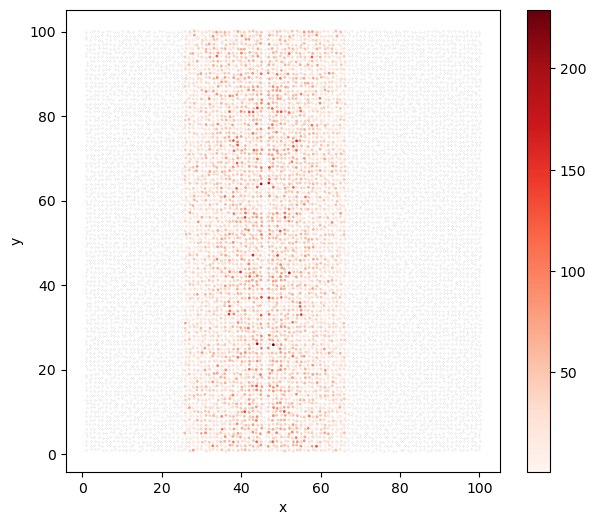

In [229]:
show_pattern(pos_w, sim_edge_list_df, pseudo_count, idx)

In [230]:
(x,y,_,_,_n_array) = data_list[idx]

In [231]:
umi_sums = _n_array
lik0 = []
lik1 = []
for i in np.linspace(-0.99, 0.99, 100):
    lik0 += [ log_joint_lik_perm_dist(
        [ i, 0.1, np.log(x.sum() / umi_sums.sum()), np.log(y.sum() / umi_sums.sum()) ,0], 
        umi_sums, 
        umi_sums, 
        x, 
        y, 
        sim_edge_list_df.distance.values,
        red_df.gap.values,
        perm=1, 
        DT=False) 
    ]   
    lik1 += [ log_joint_lik_perm_dist(
        [ i, 0.01, np.log(x.sum() / umi_sums.sum()), np.log(y.sum() / umi_sums.sum()) ,0], 
        umi_sums, 
        umi_sums, 
        x, 
        y, 
        sim_edge_list_df.distance.values,
        red_df.gap.values,
        perm=1, 
        DT=False) 
    ]   

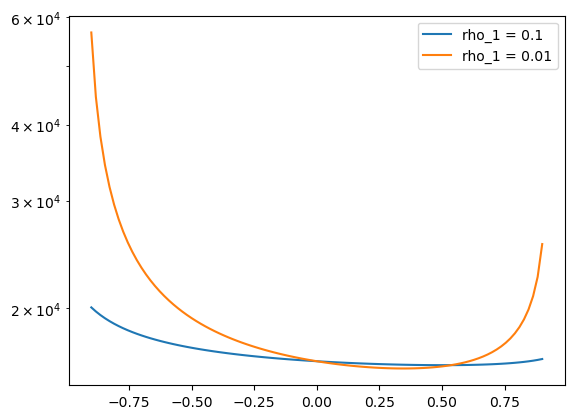

In [232]:
plt.plot(np.linspace(-0.9, 0.9, 100), lik0, label='rho_1 = 0.1')
plt.plot(np.linspace(-0.9, 0.9, 100), lik1, label='rho_1 = 0.01')
plt.legend();
plt.yscale('log')

In [241]:
opt_res_df.loc[idx:idx+1,][['rho_zero', 'pred_corr_zero', 'spearman_log_norm', 'pearson_norm']]

,rho_zero,pred_corr_zero,spearman_log_norm,pearson_norm
647,-0.9,0.069471,-0.320391,-0.306494
648,-0.8,-0.809095,-0.608033,-0.586328


In [236]:
opt_res_df.loc[647,]

sparse_frac               3.000000e-01
mu_x                     -3.000000e+00
mu_y                     -3.000000e+00
rho_zero                 -9.000000e-01
rho_one                   5.000000e-02
ind                       6.470000e+02
pred_corr_zero            6.947111e-02
pred_corr_one             5.154400e-10
pred_mu_x                -3.185682e+00
pred_mu_y                -3.132017e+00
spearman                  8.598651e-01
pearson                   8.932257e-01
spearman_log_norm        -3.203910e-01
pearson_norm             -3.064942e-01
copula_diff              -9.694711e-01
copula_one_diff          -9.000000e-01
spearman_diff            -1.759865e+00
pearson_diff             -1.793226e+00
spearman_log_norm_diff   -5.796090e-01
pearson_norm_diff        -5.935058e-01
orig_index                6.470000e+02
method_diff              -7.903940e-01
Name: 647, dtype: float64

In [200]:
grid_points_df.iloc[495,:]

sparse_frac      0.30
mu_x            -5.00
mu_y            -5.00
rho_zero        -0.90
rho_one          0.05
ind            495.00
Name: 495, dtype: float64

In [203]:
call_optimizer_dense(
    x,
    y,
    _n_array,
    _n_array,
    sim_edge_list_df.distance.values,
    red_df.gap.values,
    method='Powell',
    perm=20,
    DT=False,
    cutoff=0.9,
    num_restarts = 1
)

[-0.9159812066842157,
 0.01063226174452701,
 -4.99441346922091,
 -5.01214897473058,
 29.63277737928602,
 'copula']

In [170]:
def prepare_df(opt_res):
    spr = []
    spr2 = []
    spr3 = []
    spr4 = []
    for (x,y,_,_,_n_array) in data_list:
        #inds = np.where((x > 0) | (y > 0))[0]
        spr += [stats.spearmanr(x, y).correlation]

    for (x,y,_,_,_n_array) in data_list:
        #inds = np.where((x > 0) | (y > 0))[0]
        #spr2 += [stats.spearmanr(( x[inds] / _n_array[inds] ), ( y[inds] / _n_array[inds] )).correlation]
        spr2 += [stats.pearsonr(x, y).correlation]

    for (x,y) in data_list_norm:
        #inds = np.where((x > 0) | (y > 0))[0]
        #spr2 += [stats.spearmanr(( x[inds] / _n_array[inds] ), ( y[inds] / _n_array[inds] )).correlation]
        spr3 += [stats.pearsonr(x, y).correlation]

    for (x,y) in data_list_log:
        #inds = np.where((x > 0) | (y > 0))[0]
        #spr2 += [stats.spearmanr(( x[inds] / _n_array[inds] ), ( y[inds] / _n_array[inds] )).correlation]
        spr4 += [stats.spearmanr(x, y).correlation]

    
    opt_res_df = pd.DataFrame(opt_res, columns=['pred_corr_zero', 'pred_corr_one' ,'pred_mu_x','pred_mu_y','t_param','method'])
    
    opt_res_df = opt_res_df[['pred_corr_zero', 'pred_corr_one', 'pred_mu_x','pred_mu_y','method']].copy()
    opt_res_df = pd.concat([grid_points_df, opt_res_df], axis = 1)
    opt_res_df['spearman'] = spr
    opt_res_df['pearson'] = spr2
    opt_res_df['spearman_log_norm'] = spr4
    opt_res_df['pearson_norm'] = spr3

    opt_res_df = opt_res_df.loc[opt_res_df.method == 'copula'].copy()
    opt_res_df = opt_res_df.drop('method', axis=1)
   
    
    
    opt_res_df['copula_diff'] = opt_res_df.rho_zero - opt_res_df.pred_corr_zero
    opt_res_df['copula_one_diff'] = opt_res_df.rho_zero - opt_res_df.pred_corr_one
    opt_res_df['spearman_diff'] = opt_res_df.rho_zero - opt_res_df.spearman
    opt_res_df['pearson_diff'] = opt_res_df.rho_zero - opt_res_df.pearson
    opt_res_df['spearman_log_norm_diff'] = opt_res_df.rho_zero - opt_res_df.spearman_log_norm
    opt_res_df['pearson_norm_diff'] = opt_res_df.rho_zero - opt_res_df.pearson_norm
    #opt_res_df= opt_res_df.fillna(0)
    
    
    
    
    
    opt_res_df.loc[:,'orig_index'] = opt_res_df.index
    
    res_df_melted = pd.melt(opt_res_df, 
            id_vars = ['mu_x','mu_y', 'sparse_frac','rho_zero', 'rho_one','orig_index'], 
            value_vars=['copula_diff', 'spearman_diff','pearson_diff','spearman_log_norm_diff','pearson_norm_diff'],
            var_name = 'method', value_name = 'difference')

    
    
    opt_res_df['method_diff'] = abs(opt_res_df.copula_diff) - abs(opt_res_df.spearman_diff)

    return (res_df_melted, opt_res_df)

In [207]:
res_df_melted, opt_res_df = prepare_df(opt_res)

In [208]:
opt_res_df.shape

(1179, 22)

In [209]:
opt_res_df.sort_values(['copula_diff'],ascending=)

,sparse_frac,mu_x,mu_y,rho_zero,rho_one,ind,pred_corr_zero,pred_corr_one,pred_mu_x,pred_mu_y,...,spearman_log_norm,pearson_norm,copula_diff,copula_one_diff,spearman_diff,pearson_diff,spearman_log_norm_diff,pearson_norm_diff,orig_index,method_diff
647,0.3,-3.0,-3.0,-0.9,0.05,647,0.069471,5.154400e-10,-3.185682,-3.132017,...,-0.320391,-0.306494,-0.969471,-9.000000e-01,-1.759865,-1.793226,-0.579609,-0.593506,647,-0.790394
1102,1.0,-8.0,-3.0,-0.9,0.01,1102,-0.036317,4.487284e-03,-13.389906,-7.791037,...,-0.601088,-0.580866,-0.863683,-9.044873e-01,-1.221188,-1.286449,-0.298912,-0.319134,1102,-0.357505
914,0.5,-3.0,-8.0,-0.8,0.01,914,0.052816,2.627020e-05,-7.126940,-8.571341,...,-0.464759,-0.454547,-0.852816,-8.000263e-01,-0.999466,-1.059551,-0.335241,-0.345453,914,-0.146650
1106,1.0,-8.0,-3.0,-0.7,0.01,1106,0.099032,5.674091e-03,-7.409284,-1.748654,...,-0.440340,-0.429196,-0.799032,-7.056741e-01,-1.000768,-1.088007,-0.259660,-0.270804,1106,-0.201736
1254,1.0,-3.0,-8.0,-0.9,0.01,1254,-0.184911,4.031782e-02,-8.371895,-7.630635,...,-0.618580,-0.600771,-0.715089,-9.403178e-01,-1.174473,-1.229266,-0.281420,-0.299229,1254,-0.459383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.3,-8.0,-8.0,0.0,0.01,360,-0.384392,5.960861e-07,-8.047460,-7.869431,...,0.013134,-0.022725,0.384392,-5.960861e-07,-0.048475,-0.059222,-0.013134,0.022725,360,0.335917
454,0.3,-8.0,-3.0,0.9,0.01,454,0.400170,5.979689e-07,-8.500947,-3.281057,...,0.502123,0.511856,0.499830,8.999994e-01,0.477435,0.392133,0.397877,0.388144,454,0.022395
796,0.5,-8.0,-3.0,0.9,0.01,796,0.398123,1.276123e-12,-8.606270,-3.243228,...,0.525396,0.470186,0.501877,9.000000e-01,0.478710,0.427070,0.374604,0.429814,796,0.023168
1288,1.0,-3.0,-8.0,0.8,0.01,1288,0.250135,1.000000e-01,-3.023032,-8.113741,...,0.539105,0.531153,0.549865,7.000000e-01,0.299153,0.250447,0.260895,0.268847,1288,0.250712


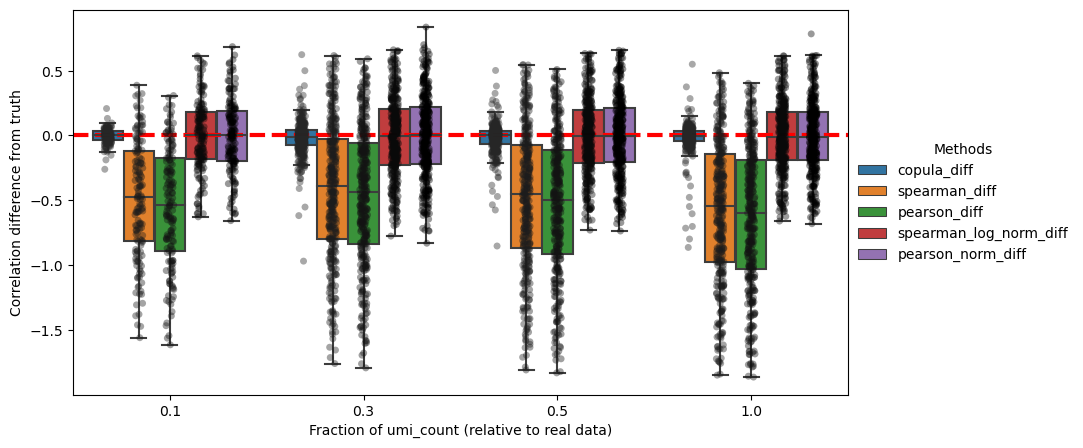

In [210]:
plt.figure(figsize=(10, 5))
sns.stripplot(x="sparse_frac", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="sparse_frac", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('Fraction of umi_count (relative to real data)', fontsize = 10)
plt.ylabel('Correlation difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 3, linestyle='--')
#plt.legend(title="Legend", bbox_to_anchor=(1, 1), loc='upper left');
leg = plt.legend(title="Methods", loc='right', bbox_to_anchor=(1.3,0.5),
          frameon=False);
plt.setp(leg.texts, fontsize='10')

plt.show()

In [252]:
from scipy.optimize import minimize, minimize_scalar
EPSILON = 1.1920929e-07
def get_dt_cdf(x, lam, DT=True):
    u_x = stats.poisson.cdf(x, lam).clip(EPSILON, 1 - EPSILON)
    u_x2 = stats.poisson.cdf(x-1, lam).clip(EPSILON, 1 - EPSILON)
    if DT:
        v = stats.uniform.rvs(size=len(x))
        r = u_x * v + u_x2 * (1 - v)
    else:
        r = (u_x + u_x2) / 2.0
    #r = (u_x + u_x2) / 2.0
    #r = u_x2
    # remove too low / too big
    idx_adjust = np.where(1 - r < EPSILON)[0]
    r[ idx_adjust ] = r[ idx_adjust ] - EPSILON
    idx_adjust = np.where(r < EPSILON)[0]
    r[ idx_adjust ] = r[ idx_adjust ] + EPSILON

    return stats.norm.ppf(r)

    

def log_joint_lik_perm_dist(params, umi_sum_1, umi_sum_2, x, y, dist_list, perm=100, DT=True, model = 'copula'):
    # get lam parameters for mu_1
    rho_zero = params[0]
    rho_one = params[1]
    coeff_list = rho_zero * np.exp(-1 * sim_edge_list_df.distance * rho_one)
    mu_1 = params[2]
    mu_2 = params[3]
    
    lam1 = umi_sum_1 * np.exp(mu_1)
    lam2 = umi_sum_2 * np.exp(mu_2)
    
    # get z
    r_x = get_dt_cdf(x, lam1, DT=DT)
    r_y = get_dt_cdf(y, lam2, DT=DT)
    if DT:
        for _ in range(perm-1):    
            r_x += get_dt_cdf(x, lam1)
            r_y += get_dt_cdf(y, lam2)
        z = np.column_stack([r_x/perm, r_y/perm])
    else:
        z = np.column_stack([r_x, r_y])
    
    # term1
    det = 1 - coeff_list**2
    term1 = np.sum(-0.5 * (((coeff_list**2)/det) * ((z[:,0]**2) + (z[:,1] ** 2)) - 2 * (coeff_list/det) * z[:,0] * z[:,1]) )
    
    term2 = (
        np.sum(np.log( stats.poisson.pmf(x, lam1).clip(EPSILON, 1 - EPSILON) )) +
        np.sum(np.log(stats.poisson.pmf(y, lam2).clip(EPSILON, 1 - EPSILON) ))
    )
    
    term3 = np.sum(-0.5 * np.log(det+EPSILON))
    logsum = term1 + term2 + term3
   
    return -logsum

def call_optimizer_dense(
    _x, 
    _y, 
    _umi_sum_1, 
    _umi_sum_2,
    dist_list,
    rho_one_start = 0.01,
    method = 'Nelder-Mead',
    perm=10,
    DT = True,
    cutoff=0.6,
    length_cutoff=20,
    model='copula',
    num_restarts = 50,
    force = False
):
    x = _x.copy()
    y = _y.copy()
    if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
        
        return ([ 0, 0, 0, 0 , 'skip' ])
    if ( (x.sum() == 0) or (y.sum() == 0) ):
        
        return ([ 0, 0, 0, 0 , 'skip' ])
    if len(x) < length_cutoff:
        
        return ([ 0, 0, 0, 0 , 'skip' ])
    umi_sum_1 = _umi_sum_1.copy()
    umi_sum_2 = _umi_sum_2.copy()
    method_type = model

    if not force:
        # If either of the arrays are too sparse we would run  
        # gaussian extimate rather than anything else
        
        if ( ((x==0).sum() / len(x) > cutoff) | ((y==0).sum() / len(y) > cutoff) ):
            
            method_type = 'skip'
        
    
    results = []
    mu_x_start = np.log(x.sum() / umi_sum_1.sum())
    mu_y_start = np.log(y.sum() / umi_sum_2.sum())
    if method_type == 'skip':
        return ([ 0, 0, 0, 0 , 'skip' ])
    else:
        for _ in range(num_restarts):
            res = minimize(
                log_joint_lik_perm_dist, 
                x0=[0.0,rho_one_start,mu_x_start,mu_y_start], 
                method = method, 
                bounds = [(-0.99, 0.99),
                          (0.0, 0.1),
                          (mu_x_start-5, 0),
                          (mu_y_start-5, 0)], 
                args=(umi_sum_1,umi_sum_2,x,y, dist_list,perm,DT,"copula"), 
                tol=1e-6
            )
            results += [res.copy()]
        best_result = min(results, key=lambda x: x['fun'])
        return list(best_result['x']) + ['copula']

In [254]:
(x,y,_,_,_n_array) = data_list[idx]

In [257]:
len(x)

2000

In [255]:
data_list[idx]

(array([14, 12, 16, ..., 45, 62, 55]),
 array([19, 15, 16, ..., 44, 72, 23]),
 -3.0,
 -3.0,
 array([ 667,  518,  910, ...,  967, 1368,  814]))

In [268]:
pseudo_count.sum(1).values.shape

(2000,)

In [266]:
data_list_norm_cop = []
i = 0
import tqdm
for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, _ = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list_norm_cop += [
        (
            pseudo_count.loc[:, 'L'+str(i)].values.astype('int'),
            pseudo_count.loc[:, 'R'+str(i)].values.astype('int'),
            mu_x, mu_y,
            pseudo_count.sum(1).values
            
        )
    ]
    i += 1

1368it [00:38, 35.37it/s]


In [269]:
opt_res_norm = Parallel(n_jobs=20, verbose=1)(
        delayed(call_optimizer_dense)(
        x,
        y,
        pseudo_count.sum(1).values,
        pseudo_count.sum(1).values,
        sim_edge_list_df.distance.values,
        method='Powell',
        perm=20,
        DT=False,
        cutoff=0.9,
        num_restarts = 1
        ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    4.4s
[Parallel(n_jobs=20)]: Done 161 tasks      | elapsed:   14.5s
[Parallel(n_jobs=20)]: Done 411 tasks      | elapsed:   35.1s
[Parallel(n_jobs=20)]: Done 761 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done 1211 tasks      | elapsed:  1.6min
[Parallel(n_jobs=20)]: Done 1368 out of 1368 | elapsed:  1.8min finished


In [270]:
def prepare_df(opt_res):
    spr = []
    spr2 = []
    spr3 = []
    spr4 = []
    for (x,y,_,_,_n_array) in data_list:
        #inds = np.where((x > 0) | (y > 0))[0]
        spr += [stats.spearmanr(x, y).correlation]

    for (x,y,_,_,_n_array) in data_list:
        #inds = np.where((x > 0) | (y > 0))[0]
        #spr2 += [stats.spearmanr(( x[inds] / _n_array[inds] ), ( y[inds] / _n_array[inds] )).correlation]
        spr2 += [stats.pearsonr(x, y).correlation]

    for (x,y) in data_list_norm:
        #inds = np.where((x > 0) | (y > 0))[0]
        #spr2 += [stats.spearmanr(( x[inds] / _n_array[inds] ), ( y[inds] / _n_array[inds] )).correlation]
        spr3 += [stats.pearsonr(x, y).correlation]

    for (x,y) in data_list_log:
        #inds = np.where((x > 0) | (y > 0))[0]
        #spr2 += [stats.spearmanr(( x[inds] / _n_array[inds] ), ( y[inds] / _n_array[inds] )).correlation]
        spr4 += [stats.spearmanr(x, y).correlation]

    
    opt_res_df = pd.DataFrame(opt_res, columns=['pred_corr_zero', 'pred_corr_one' ,'pred_mu_x','pred_mu_y','method'])
    opt_res_df = opt_res_df.loc[opt_res_df.method == 'copula']
    opt_res_df = opt_res_df[['pred_corr_zero', 'pred_corr_one', 'pred_mu_x','pred_mu_y']].copy()
    opt_res_df = pd.concat([grid_points_df, opt_res_df], axis = 1)
    opt_res_df['spearman'] = spr
    opt_res_df['pearson'] = spr2
    opt_res_df['spearman_log_norm'] = spr4
    opt_res_df['pearson_norm'] = spr3

    
    
    
    opt_res_df['copula_diff'] = opt_res_df.rho_zero - opt_res_df.pred_corr_zero
    opt_res_df['copula_one_diff'] = opt_res_df.rho_zero - opt_res_df.pred_corr_one
    opt_res_df['spearman_diff'] = opt_res_df.rho_zero - opt_res_df.spearman
    opt_res_df['pearson_diff'] = opt_res_df.rho_zero - opt_res_df.pearson
    opt_res_df['spearman_log_norm_diff'] = opt_res_df.rho_zero - opt_res_df.spearman_log_norm
    opt_res_df['pearson_norm_diff'] = opt_res_df.rho_zero - opt_res_df.pearson_norm
    #opt_res_df= opt_res_df.fillna(0)
    
    
    zero_ratio = (pseudo_count == 0).mean()
    opt_res_df.loc[:,'zero_ratio'] = [(zero_ratio.iloc[i] + zero_ratio.iloc[i + 1]) / 2 for i in range(0, len(zero_ratio) - 1, 2)]
    
    opt_res_df.loc[:,'zr_cat'] = pd.cut(opt_res_df.zero_ratio, bins=[-1.0,0.25,0.5,0.75,1.0], labels = ['below_25', 
                                                                            '25_50',
                                                                            '50_75',
                                                                             '75_100'
                                                                            ])
    
    
    
    opt_res_df.loc[:,'orig_index'] = opt_res_df.index
    
    res_df_melted = pd.melt(opt_res_df, 
            id_vars = ['mu_x','mu_y', 'zr_cat', 'sparse_frac','rho_zero', 'rho_one','orig_index'], 
            value_vars=['copula_diff', 'spearman_diff','pearson_diff','spearman_log_norm_diff','pearson_norm_diff'],
            var_name = 'method', value_name = 'difference')

    
    
    opt_res_df['method_diff'] = abs(opt_res_df.copula_diff) - abs(opt_res_df.spearman_diff)

    return (res_df_melted, opt_res_df)

In [271]:
res_df_melted, opt_res_df = prepare_df(opt_res_norm)

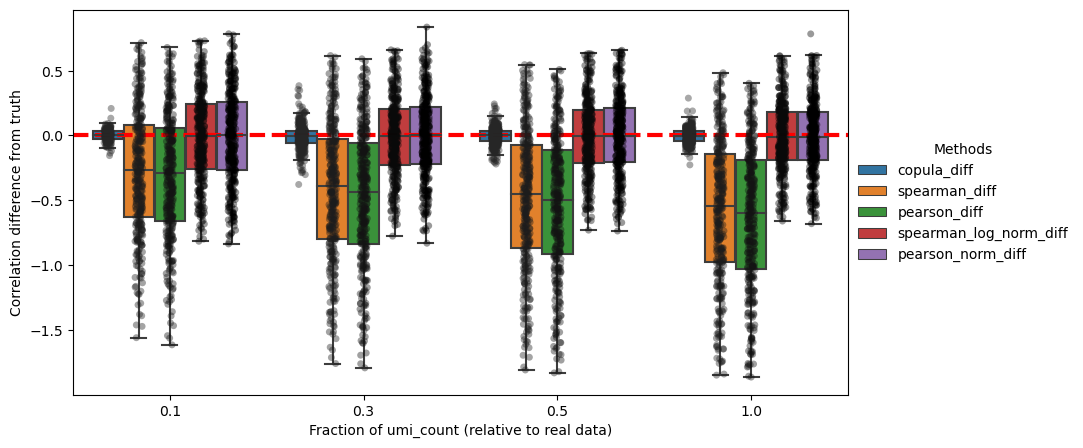

In [272]:
plt.figure(figsize=(10, 5))
sns.stripplot(x="sparse_frac", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="sparse_frac", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('Fraction of umi_count (relative to real data)', fontsize = 10)
plt.ylabel('Correlation difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 3, linestyle='--')
#plt.legend(title="Legend", bbox_to_anchor=(1, 1), loc='upper left');
leg = plt.legend(title="Methods", loc='right', bbox_to_anchor=(1.3,0.5),
          frameon=False);
plt.setp(leg.texts, fontsize='10')

plt.show()